<img src="https://raw.githubusercontent.com/MLMI2-CSSI/foundry/main/assets/foundry-black.png" width=450>

# Foundry AIRPI ptychography reconstruction Tutorial for Beginners

Friedrich T. 2021. Phase Object Reconstruction of 4D-STEM datasets using Deep Learning. :1–13. doi:10.22443/rms.mmc2021.200.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MLMI2-CSSI/foundry/blob/main/examples/dendrite-segmentation/dendrite_segmentation.ipynb)

This introduction uses Foundry to:


1. Load a predictive model from Foundry
2. reconstruct phase and amplitude from an example 4D STEM dataset using the model
This notebook is set up to run as a [Google Colaboratory](https://colab.research.google.com/notebooks/intro.ipynb#scrollTo=5fCEDCU_qrC0) notebook, which allows you to run python code in the browser, or as a [Jupyter](https://jupyter.org/) notebook, which runs locally on your machine.

The code in the next cell will detect your environment to make sure that only cells that match your environment will run.

In [1]:
try:
    import google.colab
    no_local_server=True
    no_browser=True
    globus=False
except: # when not in google colab
    no_local_server=False
    no_browser=False
    globus=True

# Installing Foundry


In [ ]:
!pip install foundry_ml


In [3]:
from foundry import Foundry

# Instantiating Foundry
To instantiate Foundry, you'll need a [Globus](https://www.globus.org) account. Once you have your account, you can instantiate Foundry using the code below. When you instantiate Foundry locally, be sure to have your Globus endpoint turned on (you can do that with [Globus Connect Personal](https://www.globus.org/globus-connect-personal)). When you instantiate Foundry on Google Colab, you'll be given a link in the cell's output and asked to enter the provided auth code.


In [4]:
f = Foundry(index="mdf", no_local_server=no_local_server, no_browser=no_browser)

Please paste the following URL in a browser:
https://auth.globus.org/v2/oauth2/authorize?client_id=984464e2-90ab-433d-8145-ac0215d26c8e&redirect_uri=https%3A%2F%2Fauth.globus.org%2Fv2%2Fweb%2Fauth-code&scope=urn%3Aglobus%3Aauth%3Ascope%3Adata.materialsdatafacility.org%3Aall+https%3A%2F%2Fauth.globus.org%2Fscopes%2Fc17f27bb-f200-486a-b785-2a25e82af505%2Fconnect+urn%3Aglobus%3Aauth%3Ascope%3Asearch.api.globus.org%3Asearch+https%3A%2F%2Fauth.globus.org%2Fscopes%2F56ceac29-e98a-440a-a594-b41e7a084b62%2Fall+urn%3Aglobus%3Aauth%3Ascope%3Atransfer.api.globus.org%3Aall+https%3A%2F%2Fauth.globus.org%2Fscopes%2F81fc4156-a623-47f2-93ad-7184118226ba%2Fauth+https%3A%2F%2Fauth.globus.org%2Fscopes%2Ffacd7ccc-c5f4-42aa-916b-a0e270e2c2a9%2Fall+openid+https%3A%2F%2Fauth.globus.org%2Fscopes%2Ffacd7ccc-c5f4-42aa-916b-a0e270e2c2a9%2Fall&state=_default&response_type=code&code_challenge=42JJ1EwwvfzfXfgZ7olzFHjOJzKg6zFgJSkVQCt3Q8k&code_challenge_method=S256&access_type=offline&prefill_named_grant=Foundry+Logi

# Prepare the input dictionary


In [5]:
# download an example data from the author
!wget https://zenodo.org/record/7034879/files/STO_small.h5?download=1

--2023-03-13 21:09:37--  https://zenodo.org/record/7034879/files/STO_small.h5?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117969856 (113M) [application/octet-stream]
Saving to: ‘STO_small.h5?download=1’

STO_small.h5?downlo 100%[===================>] 112.50M  5.29MB/s    in 21s     

2023-03-13 21:09:59 (5.28 MB/s) - ‘STO_small.h5?download=1’ saved [117969856/117969856]



In [6]:
import h5py
import numpy as np
data = h5py.File('/content/STO_small.h5?download=1')['ds']
data = np.array(data).astype(np.float32)[:20,:20] # taking a small fraction of the data as example

# wrap the 4DSTEM data and experimental parameters into a dictionary
indict = {
    "data": data,
    "batchsize":256,
    "E0": 300.0,                # Acceleration Voltage [keV]
    "apeture": 20.0,            # Apeture angle [mrad]
    "gmax": 1.6671,             # Maximum collection angle [1/A] (only used if probe_estimation_method = 'gene')
    "cbed_size": 64,            # Size of the CBEDs in pixels
    "step_size": 0.1818,        # Scan step size [A]
    "aberrations": [-1, 1e-3],  # Aberrations [C1(A), C3(mm)] C1==-1 computes the Scherzer defocus for the given C3
    "probe_estimation_method": 'avrg',
    # Aperture function estimation
    #       'gene': parameter generated(E0, apeture, gmax, aberrations) 
    #       'avrg': use PACBED to estimate a probe function (E0, apeture, aberrations) 
    "oversample": 2.0,          # Oversampling factor of the output reconstruction
    "order": ['rx','ry']        # Specify real space order of the dataset
}



# Run prediction

In [12]:
result = f.run("jwei74_wisc/Airpi_test", indict)

# Virualize the results

Text(0.5, 1.0, 'Amplitude')

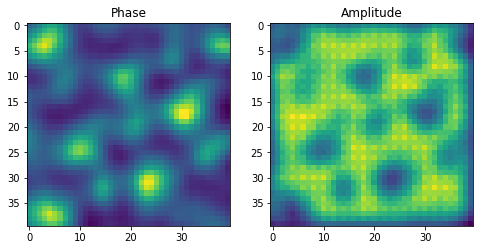

In [13]:
import numpy as np
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2, figsize=(8,8))

axs[0].imshow(np.angle(result)/np.pi)
axs[0].set_title('Phase')
axs[1].imshow(np.abs(result)/np.pi)
axs[1].set_title('Amplitude')